In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense
from tensorflow.python.keras.callbacks import EarlyStopping

In [2]:
from google.colab import files

files.upload()

Saving 1월.csv to 1월.csv


{'1월.csv': b',\xec\x9b\x94,\xeb\x82\xa0\xec\xa7\x9c,\xec\x8b\x9c\xea\xb0\x84,\xec\x82\xac\xec\x9a\xa9\xeb\x9f\x89,\xec\x8b\x9c\xea\xb0\x84\xec\xa0\x95\xea\xb7\x9c\xed\x99\x94,\xec\x98\xa8\xeb\x8f\x84\r\n0,1,1,0:15:00,238.32,2019-01-01 0:15,-5\r\n1,1,1,0:30:00,236.16,2019-01-01 0:30,-5\r\n2,1,1,0:45:00,237.24,2019-01-01 0:45,-5\r\n3,1,1,1:00:00,236.16,2019-01-01 1:00,-5\r\n4,1,1,1:15:00,234.72,2019-01-01 1:15,-5\r\n5,1,1,1:30:00,232.56,2019-01-01 1:30,-5\r\n6,1,1,1:45:00,232.56,2019-01-01 1:45,-5\r\n7,1,1,2:00:00,236.88,2019-01-01 2:00,-5\r\n8,1,1,2:15:00,236.16,2019-01-01 2:15,-5\r\n9,1,1,2:30:00,236.16,2019-01-01 2:30,-5\r\n10,1,1,2:45:00,234.72,2019-01-01 2:45,-5\r\n11,1,1,3:00:00,235.8,2019-01-01 3:00,-5\r\n12,1,1,3:15:00,236.88,2019-01-01 3:15,-5\r\n13,1,1,3:30:00,235.44,2019-01-01 3:30,-5\r\n14,1,1,3:45:00,234,2019-01-01 3:45,-5\r\n15,1,1,4:00:00,236.52,2019-01-01 4:00,-5\r\n16,1,1,4:15:00,237.24,2019-01-01 4:15,-5\r\n17,1,1,4:30:00,235.44,2019-01-01 4:30,-5\r\n18,1,1,4:45:00,235.

# **전력만 사용**

In [36]:
data = pd.read_csv("1월.csv", header=None)
data=data[1:][4]  #전력만
data=pd.DataFrame(data)
data.head()

,4
1,238.32
2,236.16
3,237.24
4,236.16
5,234.72


In [37]:
data[4]=pd.to_numeric(data[4])

In [38]:
data = np.array(data) 

#전체 날짜 수(15분단위=>4*24)
number_of_whole_day = int(data.shape[0]/96)
print(f"Number of Whole day: {number_of_whole_day}")

#하루를 예측하는 것이므로 하루를 제외한 나머지는 train+vald으로 지정
number_of_trainval_day=number_of_whole_day-1
print(f"Number of train and validation day: {number_of_trainval_day}")

#train+val에서 80%를 훈련셋으로 지정  
number_of_train_day = int(number_of_trainval_day * 0.8) 
print(f"Number of train day: {number_of_train_day}")

Number of Whole day: 30
Number of train and validation day: 29
Number of train day: 23


In [39]:
#train_data중에서 
train_data=data[:number_of_train_day*96]
print(f"Number of train data: {train_data.shape}")

valid_data=data[number_of_train_day*96:-96]
print(f"Number of validation data: {valid_data.shape}")

test_data =data[-96:]
print(f"Number of test data: {test_data.shape}")

Number of train data: (2208, 1)
Number of validation data: (576, 1)
Number of test data: (96, 1)


In [40]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

In [41]:
#데이터 스케일링(0,1 사이값으로 변환)
min_max_normalized_train_data=minmax_scaler.fit_transform(train_data)

#fit은 사용하면 안됨.train data에서 fit했던 기준들을 이용해야하기 때문
min_max_normalized_valid_data = minmax_scaler.transform(valid_data)
min_max_normalized_test_data = minmax_scaler.transform(test_data)

#스케일링된 결과
print(min(train_data), max(train_data))
print(min(min_max_normalized_train_data), max(min_max_normalized_train_data))

[120.6] [596.88]
[0.] [1.]


In [42]:
#numpy를 pandas로 변환
min_max_normalized_train_data = pd.DataFrame(min_max_normalized_train_data)[0]
min_max_normalized_valid_data = pd.DataFrame(min_max_normalized_valid_data)[0]
min_max_normalized_test_data = pd.DataFrame(min_max_normalized_test_data)[0]

In [47]:
min_max_normalized_train_data

0       0.247166
1       0.242630
2       0.244898
3       0.242630
4       0.239607
          ...   
2203    0.315193
2204    0.315193
2205    0.305367
2206    0.284203
2207    0.330310
Name: 0, Length: 2208, dtype: float64

In [44]:
#학습데이터, 결과데이터 배열로 return  
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    start = sequence.index.start
    for i in range(start, len(sequence)+start):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > start + len(sequence)-1:
            break
        # gather input and output parts of the pattern
        if start > 90:
            a = i - start
            b = end_ix - start
        else:
            a = i
            b = end_ix
        # seq_x, seq_y = sequence[a:b], sequence[end_ix]
        seq_x, seq_y = sequence[a:b], sequence[b]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [45]:
#데이터 split을 위한 값. 2개의 input, 1개의 result   
## Ex) [1, 2, 3, 4, 5], n_steps = 2 -> [[1, 2, [3]], [2, 3, [4]], [3, 4, [5]]]

n_step = 2

x_train, y_train = split_sequence(min_max_normalized_train_data, n_step)
x_valid, y_valid = split_sequence(min_max_normalized_valid_data, n_step)
x_test, y_test = split_sequence(min_max_normalized_test_data, n_step)

print(x_train.shape)
print(y_train.shape)

(2206, 2)
(2206,)


In [46]:
x_train

array([[0.24716553, 0.24263039],
       [0.24263039, 0.24489796],
       [0.24489796, 0.24263039],
       ...,
       [0.31519274, 0.31519274],
       [0.31519274, 0.30536659],
       [0.30536659, 0.28420257]])

In [ ]:
#RNN- 데이터 형변환 [samples, timesteps, features]
n_features = 1
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))

print(x_train.shape)  #shape=(2,1) 2206개 
print(y_train.shape)  #정답

(2206, 2, 1)
(2206,)


In [ ]:
#모델 정의
#모델 성능(오류율이 5%미만이면 break, 아니면 10번 시도 후에 break)
i = 0
while True and i < 10:
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_step, n_features)))  #input_shape=(2,1)
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    #model training start
    #train data로 학습후, val data로 성능평가 
    model.fit(x_train, y_train, epochs=100, verbose=1, validation_data=(x_valid, y_valid), callbacks=[early_stop])

    #학습모델로 test data 예측  
    yhat = model.predict(x_test, verbose=0)
    yhat = minmax_scaler.inverse_transform(yhat)  #원래값으로 변경

    #Mean absolute percentage error - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    result = np.mean(abs(test_data[n_step:] - yhat)/test_data[n_step:])  #test_data[n_step:]=test데이터[0],[1]의 y_train값
    if result*100 < 5:
        break
    else:
        del model
        i+=1

Epoch 1/100
69/69 [==============================] - 1s 18ms/step - loss: 0.0944 - val_loss: 0.0151
Epoch 2/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 6/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 8/100
69/69 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11

In [ ]:
result = np.mean(abs(test_data[n_step:] - yhat)/test_data[n_step:])*100
print(result)

3.040522812624654


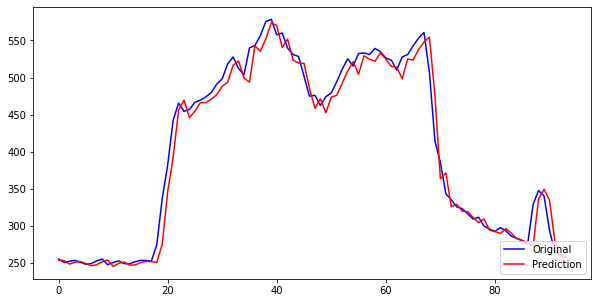

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(test_data[n_step:], 'b', label='Original')
ax1.plot(yhat, 'r', label='Prediction')
ax1.legend(loc="lower right")

**=============================================================================**

# **전력+온도**

In [48]:
data2 = pd.read_csv("1월.csv", header=None)
data2=data2[1:]
data2=data2[[4,6]]#전력+온도
data2

,4,6
1,238.32,-5
2,236.16,-5
3,237.24,-5
4,236.16,-5
5,234.72,-5
...,...,...
2876,340.2,1.8
2877,294.12,1.8
2878,263.88,1.8
2879,261,1.8


In [49]:
data2[4]=pd.to_numeric(data2[4])
data2[6]=pd.to_numeric(data2[6])

In [50]:
data2 = np.array(data2) 

#전체 날짜 수(15분단위=>4*24)
number_of_whole_day = int(len(data2)/96)
print(f"Number of Whole day: {number_of_whole_day}")

#하루를 예측하는 것이므로 하루를 제외한 나머지는 train+vald으로 지정
number_of_trainval_day=number_of_whole_day-1
print(f"Number of train and validation day: {number_of_trainval_day}")

#train+val에서 80%를 훈련셋으로 지정  
number_of_train_day = int(number_of_trainval_day * 0.8) 
print(f"Number of train day: {number_of_train_day}")

Number of Whole day: 30
Number of train and validation day: 29
Number of train day: 23


In [51]:
#train_data중에서 
train_data2=data2[:number_of_train_day*96]
print(f"Number of train data: {train_data2.shape}")

valid_data2=data2[number_of_train_day*96:-96]
print(f"Number of validation data: {valid_data2.shape}")

test_data2=data2[-96:]
print(f"Number of test data: {test_data2.shape}")

Number of train data: (2208, 2)
Number of validation data: (576, 2)
Number of test data: (96, 2)


In [52]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

In [53]:
#데이터 스케일링(0,1 사이값으로 변환)
min_max_normalized_train_data2=minmax_scaler.fit_transform(train_data2)

#fit은 사용하면 안됨.train data에서 fit했던 기준들을 이용해야하기 때문
min_max_normalized_valid_data2= minmax_scaler.transform(valid_data2)
min_max_normalized_test_data2= minmax_scaler.transform(test_data2)

In [54]:
#numpy를 pandas로 변환
min_max_normalized_train_data2 = pd.DataFrame(min_max_normalized_train_data2)
min_max_normalized_valid_data2 = pd.DataFrame(min_max_normalized_valid_data2)
min_max_normalized_test_data2 = pd.DataFrame(min_max_normalized_test_data2)

In [55]:
min_max_normalized_train_data2

,0,1
0,0.247166,0.033708
1,0.242630,0.033708
2,0.244898,0.033708
3,0.242630,0.033708
4,0.239607,0.033708
...,...,...
2203,0.315193,0.820225
2204,0.315193,0.820225
2205,0.305367,0.820225
2206,0.284203,0.820225


In [67]:
#학습데이터, 정답데이터 배열로 return  
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    start = sequence.index.start
    for i in range(start, len(sequence)+start):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > start + len(sequence)-1:
            break
        # gather input and output parts of the pattern
        if start > 90:
            a = i - start
            b = end_ix - start
        else:
            a = i
            b = end_ix
        # 전력+온도 데이터(다중요인)이므로 values값을 넣어야함.
        seq_x, seq_y = sequence[a:b].values, sequence[0][b]  
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [57]:
min_max_normalized_train_data2.head()

,0,1
0,0.247166,0.033708
1,0.242630,0.033708
2,0.244898,0.033708
3,0.242630,0.033708
4,0.239607,0.033708


In [68]:
n_step = 2

x_train2, y_train2 = split_sequence(min_max_normalized_train_data2, n_step)
x_valid2, y_valid2 = split_sequence(min_max_normalized_valid_data2, n_step)
x_test2, y_test2 = split_sequence(min_max_normalized_test_data2, n_step)

print(x_train2.shape)
print(y_train2.shape)

(2206, 2, 2)
(2206,)


In [69]:
x_train2

array([[[0.24716553, 0.03370787],
        [0.24263039, 0.03370787]],

       [[0.24263039, 0.03370787],
        [0.24489796, 0.03370787]],

       [[0.24489796, 0.03370787],
        [0.24263039, 0.03370787]],

       ...,

       [[0.31519274, 0.82022472],
        [0.31519274, 0.82022472]],

       [[0.31519274, 0.82022472],
        [0.30536659, 0.82022472]],

       [[0.30536659, 0.82022472],
        [0.28420257, 0.82022472]]])

In [70]:
#RNN- 데이터 형변환 [samples, timesteps, features]
n_features = 2
x_train2 = x_train2.reshape((x_train2.shape[0], x_train2.shape[1], n_features))
x_valid2 = x_valid2.reshape((x_valid2.shape[0], x_valid2.shape[1], n_features))
x_test2 = x_test2.reshape((x_test2.shape[0], x_test2.shape[1], n_features))

print(x_train2.shape)  
print(y_train2.shape)  #정답
print(x_test2.shape) 

(2206, 2, 2)
(2206,)
(94, 2, 2)


In [76]:
#예측값과 비교할 x_test의 전력 
test_data2_new=min_max_normalized_test_data2[0][2:]
test_data2_new=pd.DataFrame(test_data2_new)
new=[]

for i in range(2,len(min_max_normalized_test_data2)):
  new_=[]
  new_.append(test_data2_new[0][i])
  new.append(new_)
new[:5]

[[0.2819349962207105],
 [0.27210884353741494],
 [0.27588813303099025],
 [0.2781557067271353],
 [0.27286470143613006]]

In [77]:
#모델 정의
#모델 성능(오류율이 5%미만이면 break, 아니면 10번 시도 후에 break)
i = 0
while True and i < 10:
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_step, n_features)))  #input_shape=(2,1)
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    #model training start
    #train data로 학습후, val data로 성능평가 
    model.fit(x_train2, y_train2, epochs=100, verbose=1, validation_data=(x_valid2, y_valid2), callbacks=[early_stop])

    #학습모델로 test data 예측  
    yhat = model.predict(x_test2, verbose=0)  #예측전력값 (94,1)
    # yhat = minmax_scaler.inverse_transform(yhat) # 예측량=>전력+온도 (94,2)

    #예측값은 전력량 1개이고, x_test는 전력량+온도이므로 차원이 맞지않아 minmax_scaler.inverse_transform 불가
    # =>min_max_normalized_test_data2를 (0,1)사이로 정규화한 x_test를 minmax_scaler한 후, 전력량부분만 가져와 yhat(예측전력량)과 비교계산
    #Mean absolute percentage error - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    result = np.mean(abs(new - yhat)/new)  
    if result*100 < 5:
        break
    else:
        del model
        i+=1

Epoch 1/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0937 - val_loss: 0.0140
Epoch 2/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0027
Epoch 3/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 4/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 5/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 6/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 7/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 9/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 10/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0018
Ep

In [78]:
#Mean absolute percentage error - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
result =np.mean(abs(new - yhat)/new) *100
print(result)

4.549999017809943


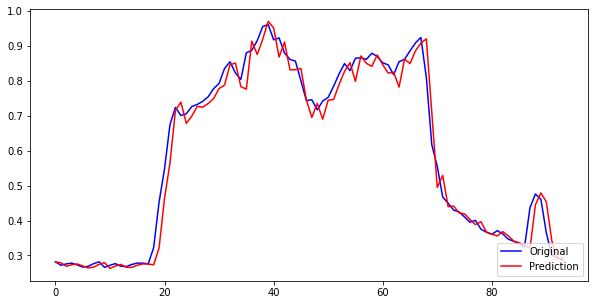

In [79]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(new, 'b', label='Original')
ax1.plot(yhat, 'r', label='Prediction')
ax1.legend(loc="lower right")